# The Adaptive Variant of Frank-Wolfe Method with Inexact Gradient

## Problem formulation

PageRank[1] problem for Frank-Wolf methods is shown below:

$$
f(x) = \frac{1}{2}\left\lVert{Ax}\right\rVert_2^2 \to \min_{x\in\Delta^n_{1}}
$$

, where:

$$
A = I - P^\intercal
$$

$I$ – identity matrix of size $n\times n$, $P$ – stochastic transit matrix, $P \in \R^{n\times n}$

Gradient of the given function is represented below:

$$
\nabla f(x) = A^\intercal A x
$$

[1]: Efficient numerical methods to solve sparse linear equations with application to PageRank, Anikin A., Gasnikov A., et al, 2022


#  Implementation of the Adaptive Frank-Wolfe algorithm with the Erroneous Conditional Oracle

In [12]:
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from scipy import interpolate

/var/folders/hm/6t9tp9rj3tjbvlllnvdyzl2h0000gn/T/ipykernel_31949/2996202092.py:6: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [13]:
from aecg import AECG
from ecg import ECG
from helper import PageRankObjective
from helper import BoxSetLMO
from helper import CWEOracle
from helper import Boundedness
from helper import StepSizeStrategy

# Configure `seed` for reproducibility of the solution
np.random.seed(2025)

# Size of the problem
n = 100

# Relative Error [0; 0.5)
eps = 0.4

# Objective parameters
A = np.random.randn(n, n)
# Normalize columns to sum to 1
A /= A.sum(axis=0, keepdims=True)
# Damping factor to simulate random surfing
d = 0.85
A = d * A + (1 - d) / n * np.ones((n, n))

# Box Set properties
lower_bound = np.zeros(n)
upper_bound = np.ones(n)

# Objective function
objective = PageRankObjective(A)

# Number of iterations
max_iterations = 50

# Coordinate-wise erroneous oracle
erroneous_oracle = CWEOracle(epsilon=eps)

# Linear minimization oracle
linear_minimization_oracle = BoxSetLMO(lower_bound=lower_bound, upper_bound=upper_bound)

# Starting point
w0 = np.random.uniform(lower_bound, upper_bound)
print(f"{w0=}")

# M
M = np.linalg.norm((objective.gradient(w0) + eps).max())
print(f"{M=}")

# R
R = (upper_bound - lower_bound).max()
print(f"{R=}")

# Lipschitz-gradient constant
L = np.linalg.eigvals(A).max().astype(np.float64)
print(f"{L=}")


# Helper functions to create algorithms
def create_ecg(label: str, boundedness: Boundedness) -> ECG:
    return ECG(
        label=label,
        max_iterations=max_iterations,
        objective=objective,
        eo=erroneous_oracle,
        lmo=linear_minimization_oracle,
        boundedness=boundedness,
        epsilon=eps,
        M=M,
        R=R,
        keep_history=True,
    )


def create_aecg(label: str, step_size: StepSizeStrategy) -> AECG:
    return AECG(
        label=label,
        max_iterations=max_iterations,
        objective=objective,
        eo=erroneous_oracle,
        lmo=linear_minimization_oracle,
        step_size=step_size,
        keep_history=True,
    )

w0=array([0.36069774, 0.62576319, 0.66089174, 0.61753162, 0.75143678,
       0.41718157, 0.91098484, 0.61638778, 0.90589306, 0.85262363,
       0.19471837, 0.5900979 , 0.13379646, 0.97431452, 0.85052977,
       0.19524228, 0.28296142, 0.49836546, 0.47422049, 0.28228967,
       0.77847995, 0.60104008, 0.69028006, 0.81820416, 0.26751572,
       0.62081961, 0.46539328, 0.31459664, 0.56049738, 0.27800192,
       0.00674222, 0.47725842, 0.88688276, 0.63598492, 0.01610979,
       0.45219541, 0.75646378, 0.42602322, 0.64332049, 0.11099323,
       0.44799004, 0.55898342, 0.81703088, 0.27296317, 0.85620375,
       0.38771043, 0.05646527, 0.49314916, 0.91312248, 0.72627596,
       0.88995306, 0.0143258 , 0.80195037, 0.75358831, 0.6931034 ,
       0.22338473, 0.05167648, 0.86123882, 0.07084993, 0.66721515,
       0.65355717, 0.59274283, 0.97274643, 0.14428485, 0.12476156,
       0.40285814, 0.97585263, 0.84925877, 0.88171524, 0.43679679,
       0.66096955, 0.37712697, 0.88802933, 0.30751073, 0.07

/var/folders/hm/6t9tp9rj3tjbvlllnvdyzl2h0000gn/T/ipykernel_31949/1566630431.py:55: ComplexWarning: Casting complex values to real discards the imaginary part
  L = np.linalg.eigvals(A).max().astype(np.float64)


## Boundedness

$$
\beta = \begin{cases} 
    0, \;\; L_t < +\infty, \\
    1, \;\; L_t \leqslant L. 
    \end{cases},\forall t \geqslant 0
$$

# Iteration-dependent step-size.

Let the-step size is dependent on iteration number $t$:

$$
\eta_t = \frac{2}{t + 2}, \forall t \geqslant 0
$$

$$
L_t = \frac{(t + 2)\left((f^{t+1} - f^t)(t+2) - 2 (\langle\hat{g}^t, p^{t+1}\rangle + \beta \varepsilon M R)\right)}{2||{p^{t+1}}||^2}
$$

$$
f^t - f^* \leqslant (1 + \beta) \varepsilon M R + \frac{4 \max\limits_{i=\overline{0,t-1}}\Bigl\{L_i R^2\Bigr\}}{t+2},
$$

# L-smoothness constant dependent step-size

$$
\eta_t = -\frac{\beta \varepsilon M R + \langle\hat{g}^t, p^{t+1}\rangle}{L_t ||p^{t+1}||^2}
$$

$$
f^t - f^* \geqslant \frac{\min\limits_{t=\overline{0,N-1}}\Bigl(\beta\varepsilon M R + \langle\hat{g}^t, p^{t+1}\rangle)^2}{2 R^2}\sum_{t=0}^{N-1}\frac{1}{L_t}. 
$$

In [14]:
ecg = [
    create_ecg(
        r"ECG with the Adaptive $L_t$, $\beta={}$".format(boundedness), boundedness
    )
    for boundedness in Boundedness
]

In [15]:
from helper import SmoothnessStepSizeStrategy


class StepSizeWrapper:
    """
    A wrapper for |StepSizeStrategy| to print table of
    intermediate results.
    """

    _PRINT_TABLE = False

    _L: float
    _wrappee: StepSizeStrategy

    def __init__(self, wrappee: StepSizeStrategy, L: float):
        self._wrappee = wrappee
        self._L = L
        self._print_table(r"$    t     L_t    L$")
        self._t = 0

    def __call__(
        self,
        g_hat: np.ndarray,
        p: np.ndarray,
    ) -> float:
        return self._wrappee(g_hat, p)

    def adjust(self):
        self._t += 1
        self._wrappee.adjust()

    def adapt(self):
        self._wrappee.adapt()

    @property
    def _boundedness(self) -> float:
        return self._wrappee._boundedness

    def is_adapted(
        self,
        f: np.ndarray,
        f_next: np.ndarray,
        g_hat: np.ndarray,
        p: np.ndarray,
    ) -> bool:
        result = self._wrappee.is_adapted(f, f_next, g_hat, p)
        self._print_table(f"{self._t:6d} {self._wrappee._L_t:10.3e} {self._L:10.1f}")
        return result

    def _print_table(self, row: str):
        if self._PRINT_TABLE:
            print(row)

In [16]:
def make_aecg_label(beta: int) -> str:
    return r"Adaptive ECG, $\beta = {}$".format(beta)

aecg = [
    create_aecg(
        label=make_aecg_label(boundedness),
        step_size=StepSizeWrapper(
            SmoothnessStepSizeStrategy(eps, L, M, R, boundedness), L
        ),
    )
    for boundedness in Boundedness
]

# Results

In [17]:
# Plot helper functions

current_marker = 0
markers = ["o", "^", "s"]


def plot_line(
    values: list[float],
    label: str,
    show_marker: bool = False,
    smooth: bool = True,
):
    global current_marker
    x = np.array(range(len(values)))
    if smooth:
        X = np.linspace(x.min(), x.max(), 200)
        Y = interpolate.make_interp_spline(x, values, k=2)(X)
    else:
        X = x
        Y = values
    if show_marker:
        next_marker = markers[current_marker % len(markers)]
        current_marker += 1
    else:
        current_marker = 0
        next_marker = None
    plt.plot(
        X,
        Y,
        label=label,
        linewidth=0.75,
        marker=next_marker,
        markevery=10,
    )


def make_plot(
    title: str,
    xlabel: str,
    ylabel: str,
    legend: list[str] | None = None,
) -> plt.Figure:
    # TODO(geaden): Put under parameter
    # plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # Configure legend
    if legend is None:
        plt.legend()
    elif len(legend) == 0:
        pass
    else:
        plt.legend(legend)
    fig = plt.gcf()
    plt.tight_layout()
    plt.show()
    return fig


def save_image(fig: plt.Figure, filename: str):
    fig.savefig(filename, dpi=300)

## Iteration-dependent step-size

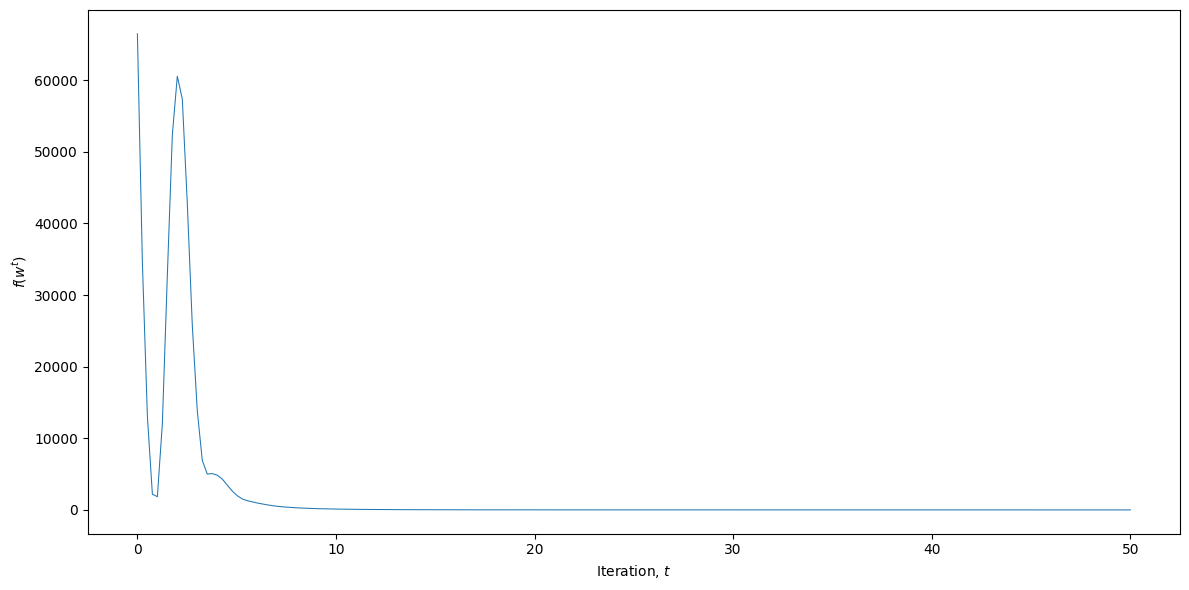

In [18]:
plt.figure(figsize=(12, 6))

for algorithm in ecg:
    algorithm.solve(w0)

values = [objective(w) for w, _ in algorithm.history]
plot_line(values, algorithm.label, show_marker=False)

# Comparison of results
fig = make_plot(
    r"ECG for PageRank Problem with the Iteration-dependent Step-size Strategy and Adaptive $L_t$",
    r"Iteration, $t$",
    r"$f(w^t)$",
    legend=[],
)

In [19]:
save_image(fig, "images/ecg_adaptive_lt")

## $L_t$

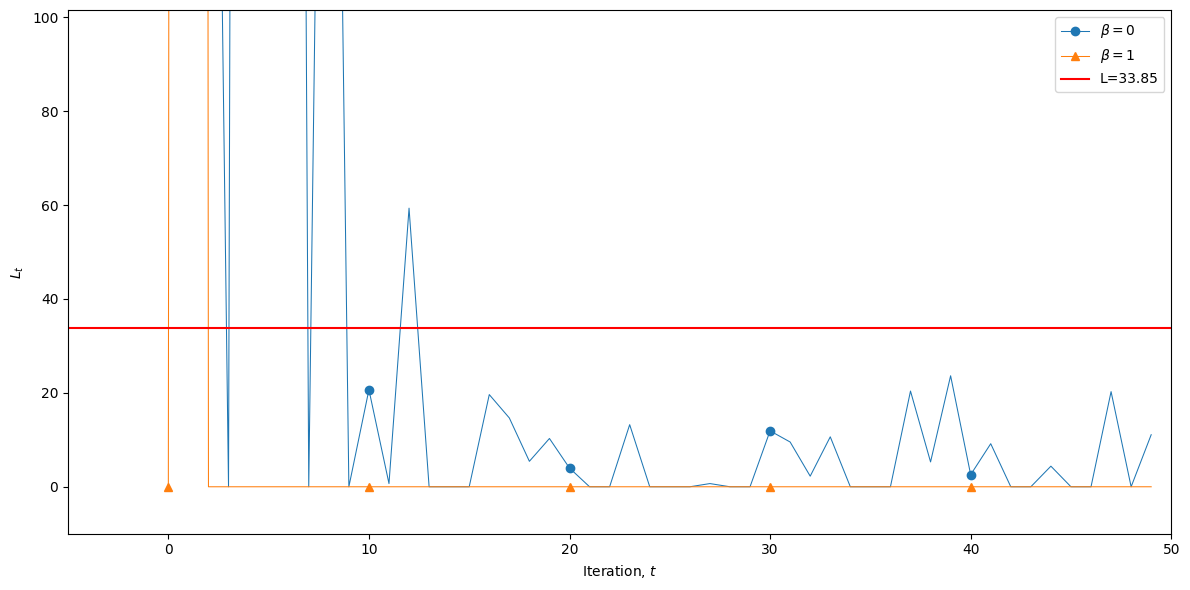

In [20]:
plt.figure(figsize=(12, 6))

labels = [r"$\beta=0$", r"$\beta=1$"]
for algorithm in ecg:
    plot_line(
        algorithm.Lt,
        label=algorithm.label,
        show_marker=True,
        smooth=False,
    )

plt.axhline(y=L, color="r", linestyle="-")
plt.axis([-5, 50, -10, L + L * 2])

labels += [f"L={L:.2f}"]
fig = make_plot(
    title=r"$L_t$ in ECG with the Adaptive $L_t$ for PageRank problem",
    xlabel="Iteration, $t$",
    ylabel="$L_t$",
    legend=labels,
)

In [21]:
save_image(fig, "images/adaptive_lt.png")

## L-smoothness constant-dependent step-size

In [22]:
for algorithm in aecg:
    algorithm.solve(w0)

/Users/geaden/phd/adaptive_erroneous_conditional_gradient/helper.py:298: RuntimeWarning: overflow encountered in multiply
  denominator = np.multiply(


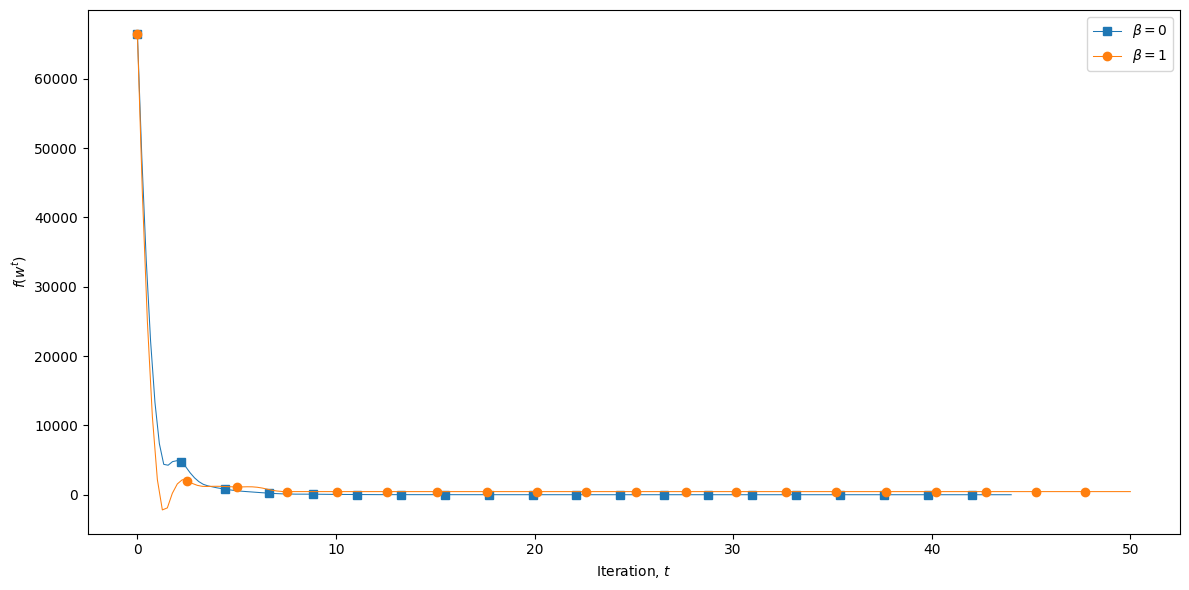

In [23]:
plt.figure(figsize=(12, 6))

for algorithm in aecg:
    values = [objective(x) for x, _ in algorithm.history]
    plot_line(values, label=algorithm.label, show_marker=True)

fig = make_plot(
    title=r"Adaptive ECG for PageRank problem with L-smoothness constant-dependent step-size strategy",
    xlabel=r"Iteration, $t$",
    ylabel=r"$f(w^t)$",
    legend=[r"$\beta=0$", r"$\beta=1$"],
)

In [24]:
save_image(fig, "images/aecg.png")

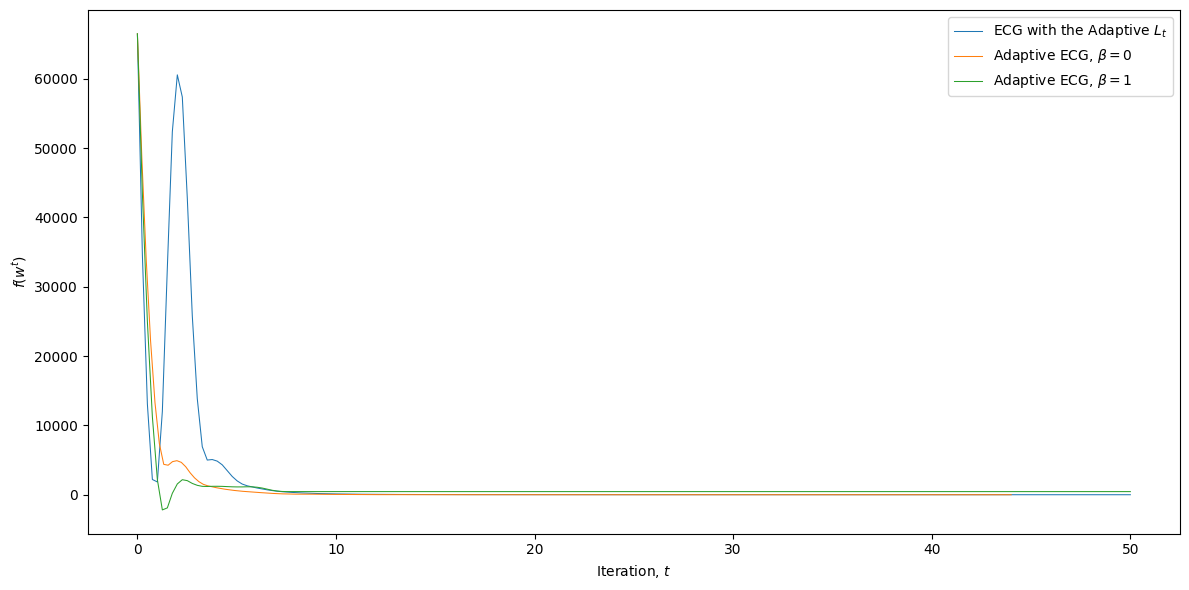

In [25]:
plt.figure(figsize=(12, 6))

# Correct label
ecg[0]._label = r"ECG with the Adaptive $L_t$"

for algorithm in [ecg[0]] + aecg:
    values = [objective(x) for x, _ in algorithm.history]
    plot_line(values, label=algorithm.label)

fig = make_plot(
    title="Comparison of on-Adaptive and Adaptive variants of ECG",
    xlabel="Iteration, $t$",
    ylabel=r"$f(w^t)$",
)

In [26]:
save_image(fig, "images/comparison.png")

$$
\delta^t := f^t - f^*
$$

$$
\delta^{t+1} \leqslant \frac{t}{t + 2}\delta^t + \frac{2(1 + \beta)\varepsilon M R}{t + 2} + \frac{4 L_t R^2}{(t + 2)^2}
$$

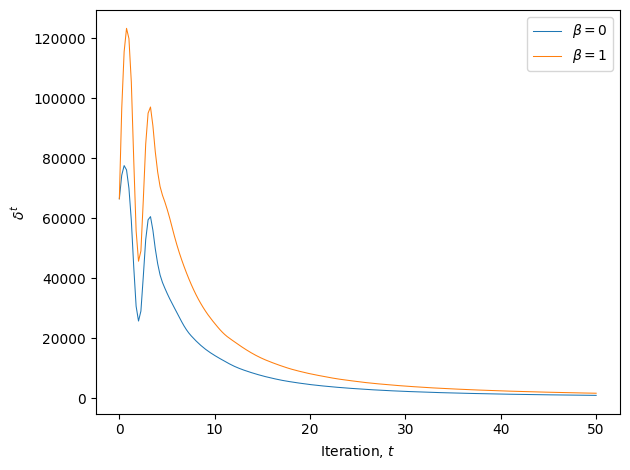

In [27]:
labels = [r"$\beta=0$", r"$\beta=1$"]

for algorithm in ecg:
    algorithm.solve_delta()
    plot_line(algorithm.delta, label=r"$\delta^{t}$", show_marker=False)

fig = make_plot(
    title=r"$\delta^{t}$",
    xlabel=r"Iteration, $t$",
    ylabel=r"$\delta^{t}$",
    legend=labels,
)

In [28]:
save_image(fig, "images/delta_t.png")